In [1]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.impute import KNNImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# seed
np.random.seed(0)

## Funciones para demostración empírica

In [2]:
"""
    Gamma: retorna el margen
    input:
        X: numpy array (n, d)
        Y: numpy array (n)
    output:
        gamma: float
"""
def gamma(X, Y):
    perceptron = Perceptron(tol=None)
    perceptron.fit(X, Y)
    Y_predicted = perceptron.predict(X)
    gamma = np.inf
    
    for i in range(X.shape[0]):
        if Y[i] * Y_predicted[i] < gamma:
            gamma = Y[i] * Y_predicted[i]
        
    return gamma

"""
    linearly_separable: Verifica si data es linealmente separable
    input:
        X: numpy array (n, d)
        Y: numpy array (n)
    output:
        bool
"""
def linearly_separable(X, Y):
    perceptron = Perceptron(tol=None)
    perceptron.fit(X, Y)
    Y_predicted = perceptron.predict(X)
    
    for i in range(X.shape[0]):
        if Y[i] * Y_predicted[i] < 0:
            return False
        
    return True

"""
    convert_to_ls: borra elementos que no sirven
    input:
        X: numpy array (n, d)
        Y: numpy array (n)
    output:
        X, Y
"""
def convert_to_ls(X, Y):
    
    perceptron = Perceptron(tol=None)
    perceptron.fit(X, Y)
    Y_predicted = perceptron.predict(X)
    Y=np.array(Y)
    X=np.array(X)
    len_Y = Y.shape[0]
    i = 0
    
    while i < len_Y:
        if Y[i] * Y_predicted[i] < 0:
 #           print(X.shape)
  #          print(Y.shape)
   #         print(i)
    #        print("\n")            
            Y = np.delete(Y, i,0)
            X = np.delete(X, i,0)
            Y_predicted = np.delete(Y_predicted, i)
            
            len_Y = Y.shape[0]
        else :
            i += 1
    
    return X, Y

"""
    max_norm: calcula la maxima norma de los vectores filas de X,
        donde cada x_i es un vecetor de atributos
    input:
        X: numpy array
    output:
        max_norm_x: float
"""
def max_norm(X):
    max_norm_x = 0
    for x in X:
        if np.linalg.norm(x) >= max_norm_x:
            max_norm_x = np.linalg.norm(x)
    return max_norm_x

# Dataset 1

## Carga data

In [3]:
data = pd.read_csv('datasets/breast-cancer-wisconsin.csv', sep=",")

data.columns = [
    "ID",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Result"
]

print("Shape breast cancer wisconsin: ", data.shape)

Shape breast cancer wisconsin:  (698, 11)


## Imputación (Knn) y detalles encoding

In [4]:
data = data.drop("ID", axis=1)

data = data.replace(['?'], np.nan)

imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)

"""data.loc[data['Result'] == "Benign", 'Result'] = 2
data.loc[data['Result'] == "Malignant", 'Result'] = 4
"""

data.loc[data['Result'] == 2, 'Result'] = "Benign"
data.loc[data['Result'] == 4, 'Result'] = "Malignant"

print("Shape breast cancer wisconsin: ", data.shape)

Shape breast cancer wisconsin:  (698, 10)


## Análisis exploratorio

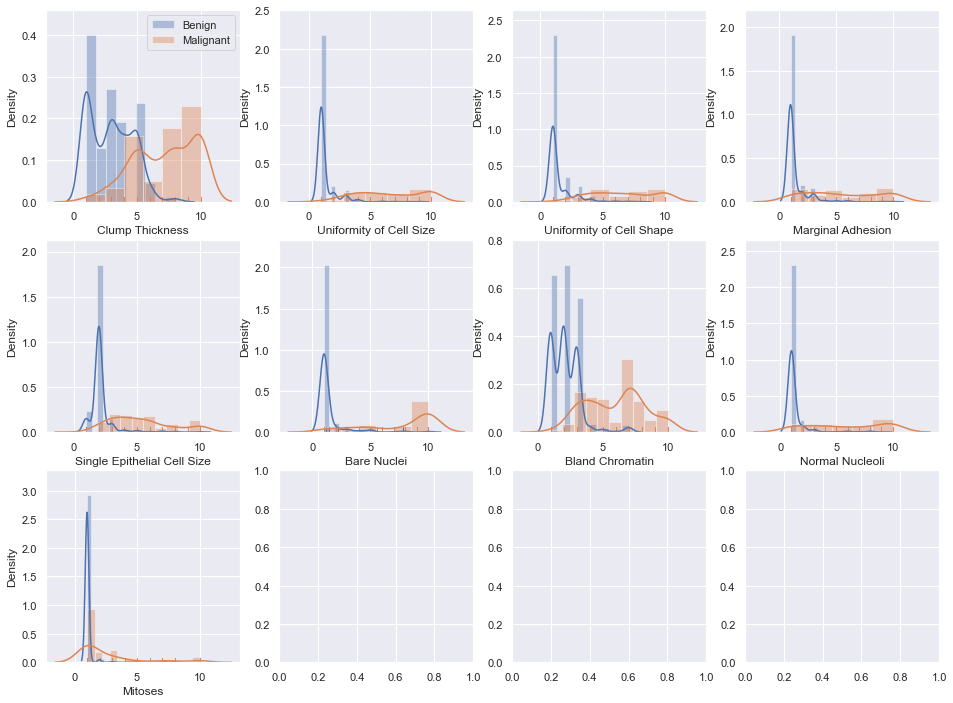

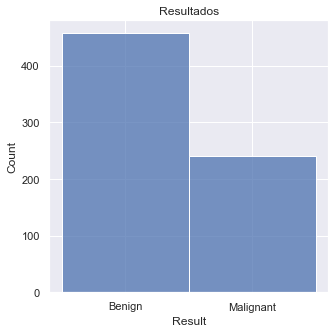

In [5]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=4)

for i, column in enumerate(data.columns[:-1]):
    for result in ["Benign", "Malignant"]:
        target = data.loc[data['Result'] == result]
        sns.distplot(target[column], rug=True, kde=True, ax=axes[i//4,i%4], label=result)
    if i==0:
        axes[0,0].legend()
        
"""data.loc[data['Result'] == "Benign", 'Result'] = 2
data.loc[data['Result'] == "Malignant", 'Result'] = 4"""

fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["Result"], palette="Blues_d",ax=ax, label=["Benign", "Malignant"])
ax.set_title('Resultados')
plt.show()

## División data

In [6]:
data.loc[data["Result"] == "Benign" ,"Result"] = 1
data.loc[data["Result"] == "Malignant", "Result"] = -1

data["Result"] = data["Result"].astype(int)

predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["Result"]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

## $\gamma$, R y cota

In [7]:
max_norm_dataset_1 = max_norm(X_train_vals)
g = gamma(X, y)
bound = max_norm_dataset_1**2 / g**2

print("R:", max_norm_dataset_1)
print("Gamma: ", g)
print("Cota: ", bound)
print("Linealmente separables?:", linearly_separable(X, y))

R: 28.5657137141714
Gamma:  -1
Cota:  816.0000000000001
Linealmente separables?: False


## Perceptrón directo

In [8]:
scores = list()
no_iterations = range(1, int(bound*10.5), 10)

for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)

    train_acc = perceptron.score(X_train_vals, y_train_vals)
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-', linewidth=0.5)

KeyboardInterrupt: 

## Perceptrón con datos linealmente separables

In [ ]:
from sklearn.model_selection import train_test_split

predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["Result"]

X, y = convert_to_ls(X, y)
print("Datos convertidos?:", linear_separable(X, y))

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

scores = list()
no_iterations = range(1, int(bound*10.5), 10)

for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)

    train_acc = perceptron.score(X_train_vals, y_train_vals)
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-', linewidth=0.5)

# Dataset 2

## Carga dataset

In [ ]:
data = pd.read_csv('datasets/Skin_NonSkin.txt', sep="\t")
print("Nan?: \n", data.isna().sum())

data.columns = ["B", "G", "R", "SkinNonSkin"]
print("Shape SkinNonSkin: ", data.shape)

## Análisis exploratorio

In [ ]:
fig, axes = plt.subplots(figsize=(9*3, 9), nrows=1, ncols=3)

"""data[data["SkinNonSkin"]==1] = "Skin"
data[data["SkinNonSkin"]==2] = "NonSkin" """

for i, column in enumerate(data.columns[:-1]):
    for result in [1, 2]:
        target = data.loc[data['SkinNonSkin'] == result]
        sns.distplot(target[column], rug=True, kde=True, ax=axes[i], label=result)
    if i==0:
        axes[0].legend()

data.loc[data["SkinNonSkin"] == 1, "SkinNonSkin"] = "Skin"
data.loc[data["SkinNonSkin"] == 2, "SkinNonSkin"] = "NonSkin"

fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["SkinNonSkin"], palette="Blues_d",ax=ax, label=["Skin", "NonSkin"])
ax.set_title('Resultados')
plt.show()

print(data)

In [ ]:
data.loc[data["SkinNonSkin"] == "Skin", "SkinNonSkin"] = 1
data.loc[data["SkinNonSkin"] == "NonSkin", "SkinNonSkin"] = -1

data["SkinNonSkin"] = data["SkinNonSkin"].astype(int)

predictors = data.columns[:-1]
x = data[predictors]
info = data[predictors]

y = data["SkinNonSkin"]

from itertools import permutations 

perm = list(permutations(data.columns[:-1], 1)) + list(permutations(data.columns[:-1], 2))

predictors = data.columns[:-1]
x = data[predictors]
info = data[predictors]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(x, y, info, test_size=0.5, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.5, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

X, Y = convert_to_ls(X_val_vals, y_val_vals)

#print(linearly_separable(X, Y))
    
from pandas.plotting import scatter_matrix

data = pd.DataFrame(X, columns=["B", "G", "R"])
data["SkinNonSkin"] = Y

max_norm_x = max_norm(X)
g = gamma(X, Y)
bound = max_norm_x**2 / g**2

print("R:", max_norm_x)
print("Gamma: ", g)
print("Cota: ", bound)

In [ ]:
scores = list()

for i in range(1, int(bound*1.1), 1000):
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X, Y)
    scores.append(perceptron.score(X, Y))

fig, ax1 = plt.subplots()

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(range(1, int(bound*1.1), 1000), scores, 'o-')

# Dataset 3

### Para el dataset Iris, separamos los datos en 3 subdataset, donde el subdataset de las clases tipos Virginica-Versicolor es no-lineal, y los subdataset de Setosa-Virginica y Setosa-Versicolor  son linealmente separables.

## Análisis  Dataset Virginica-Versicolor

## Carga data

In [9]:
data = pd.read_csv('datasets/iris-virgi-versi.data', sep=",")

data.columns = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width",
    "class"    
]

print("Shape subdataset Virginica-Versicolor: ", data.shape)

Shape subdataset Virginica-Versicolor:  (99, 5)


## Análisis exploratorio

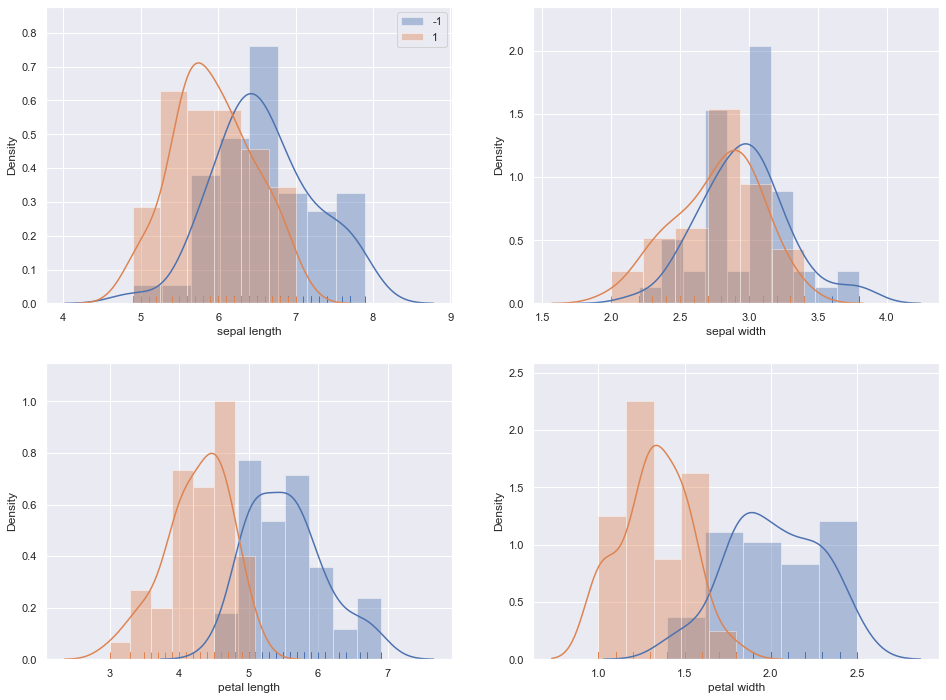

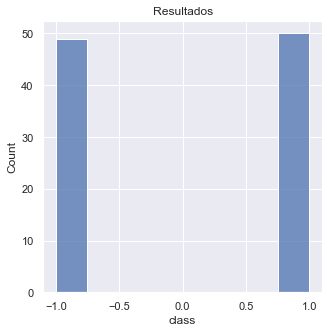

In [10]:
data.loc[data['class'] == 'Iris-virginica', 'class'] = -1
data.loc[data['class'] == 'Iris-versicolor', 'class'] = 1

fig, axes = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
for i, column in enumerate(data.columns[:-1]):
    for result in [-1, 1]:
      target = data.loc[data['class'] == result]
      sns.distplot(target[column], rug=True, kde=True, ax=axes[i//2,i%2], label=result)
      if i==0:
        axes[0,0].legend()
        
fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["class"], palette="Blues_d",ax=ax, label=["Iris-virginica", "Iris-versicolor"])
ax.set_title('Resultados')
plt.show()

## División data

In [11]:
data["class"] = data["class"].astype(int)
print(data)
predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["class"]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

    sepal length  sepal width  petal length  petal width  class
0            5.8          2.7           5.1          1.9     -1
1            7.1          3.0           5.9          2.1     -1
2            6.3          2.9           5.6          1.8     -1
3            6.5          3.0           5.8          2.2     -1
4            7.6          3.0           6.6          2.1     -1
..           ...          ...           ...          ...    ...
94           5.7          3.0           4.2          1.2      1
95           5.7          2.9           4.2          1.3      1
96           6.2          2.9           4.3          1.3      1
97           5.1          2.5           3.0          1.1      1
98           5.7          2.8           4.1          1.3      1

[99 rows x 5 columns]


## $\gamma$, R y cota

In [12]:
max_norm_dataset_1 = max_norm(X_train_vals)
g = gamma(X, y)
bound = max_norm_dataset_1**2 / g**2

print("R:", max_norm_dataset_1)
print("Gamma: ", g)
print("Cota: ", bound)
print("Linealmente separables?:", linearly_separable(X, y))

R: 10.906420127612911
Gamma:  -1
Cota:  118.95000000000003
Linealmente separables?: False


## Perceptrón directo

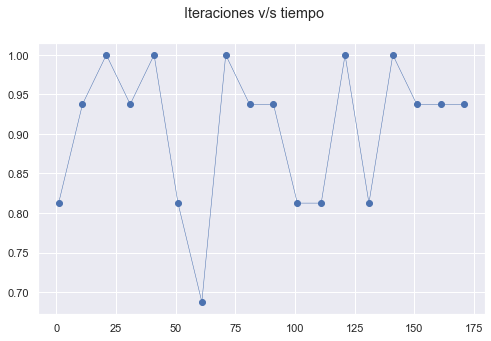

In [16]:
scores = list()
no_iterations = range(1, int(bound*1.5), 10)
for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)    
    train_acc = perceptron.score(X_train_vals, y_train_vals)    
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-o', linewidth=0.5)

## Perceptrón con datos linealmente separables

Datos convertidos?: True


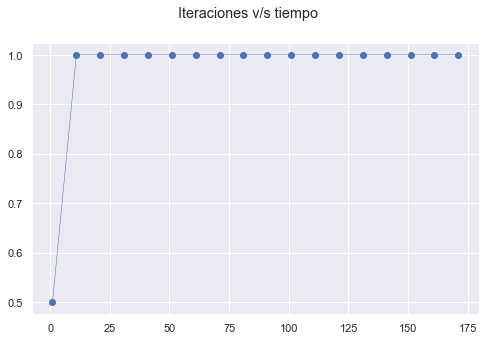

In [17]:
from sklearn.model_selection import train_test_split

predictors = data.columns[:-1]
X = data[predictors]
y = data["class"]
X, y = convert_to_ls(X, y)
print("Datos convertidos?:", linearly_separable(X, y))

X=pd.DataFrame(X)
y=pd.DataFrame(y)

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, X, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

scores = list()
no_iterations = range(1, int(bound*1.5), 10)

for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)

    train_acc = perceptron.score(X_train_vals, y_train_vals)
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-o', linewidth=0.5)

## Análisis  Dataset Setosa-Versicolor

## Carga data

In [18]:
data = pd.read_csv('datasets/iris-setosa-versi.data', sep=",")

data.columns = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width",
    "class"    
]

print("Shape subdataset Setosa-Versicolor: ", data.shape)

Shape subdataset Setosa-Versicolor:  (99, 5)


## Análisis exploratorio

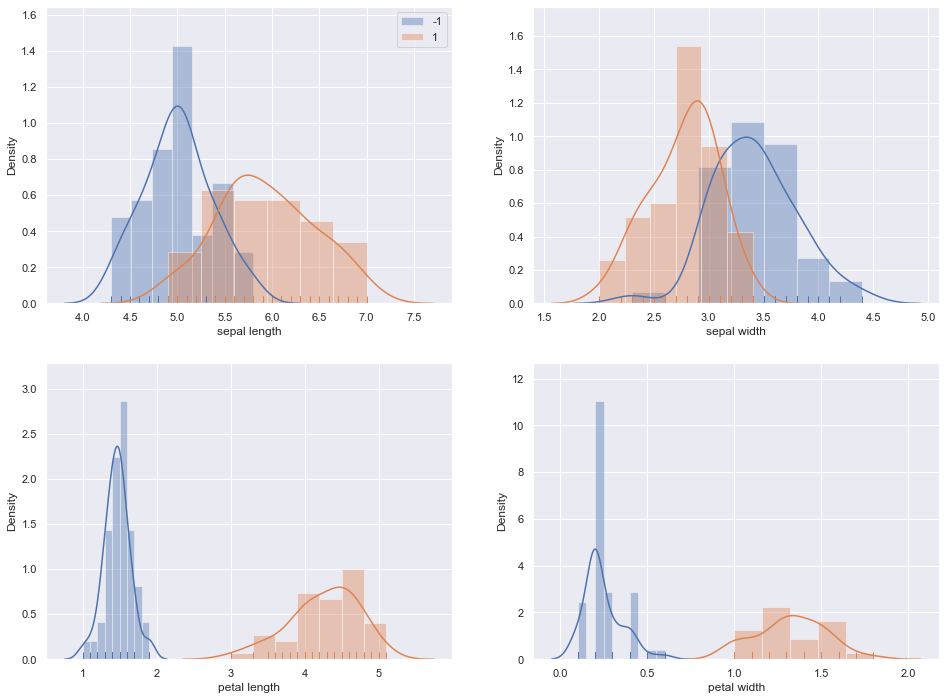

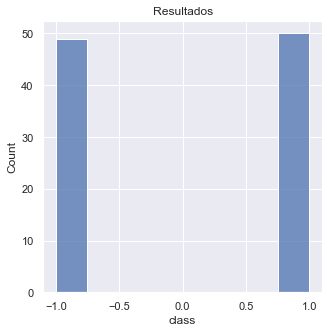

In [19]:
data.loc[data['class'] == 'Iris-setosa', 'class'] = -1
data.loc[data['class'] == 'Iris-versicolor', 'class'] = 1

fig, axes = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
for i, column in enumerate(data.columns[:-1]):
    for result in [-1, 1]:
      target = data.loc[data['class'] == result]
      sns.distplot(target[column], rug=True, kde=True, ax=axes[i//2,i%2], label=result)
      if i==0:
        axes[0,0].legend()
        
fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["class"], palette="Blues_d",ax=ax, label=["Iris-virginica", "Iris-versicolor"])
ax.set_title('Resultados')
plt.show()

## División data

In [20]:
data["class"] = data["class"].astype(int)
print(data)
predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["class"]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

    sepal length  sepal width  petal length  petal width  class
0            4.9          3.0           1.4          0.2     -1
1            4.7          3.2           1.3          0.2     -1
2            4.6          3.1           1.5          0.2     -1
3            5.0          3.6           1.4          0.2     -1
4            5.4          3.9           1.7          0.4     -1
..           ...          ...           ...          ...    ...
94           5.7          3.0           4.2          1.2      1
95           5.7          2.9           4.2          1.3      1
96           6.2          2.9           4.3          1.3      1
97           5.1          2.5           3.0          1.1      1
98           5.7          2.8           4.1          1.3      1

[99 rows x 5 columns]


## $\gamma$, R y cota

In [21]:
max_norm_dataset_1 = max_norm(X_train_vals)
g = gamma(X, y)
bound = max_norm_dataset_1**2 / g**2

print("R:", max_norm_dataset_1)
print("Gamma: ", g)
print("Cota: ", bound)
print("Linealmente separables?:", linearly_separable(X, y))

R: 9.136739024400336
Gamma:  1
Cota:  83.48
Linealmente separables?: True


## Perceptrón directo

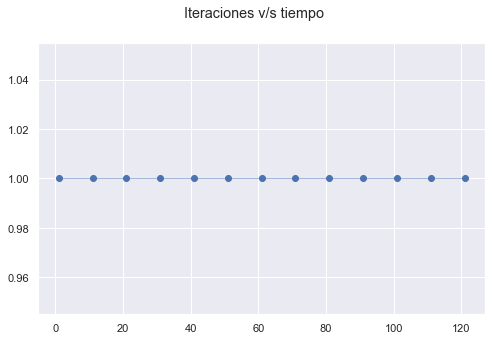

In [23]:
scores = list()
no_iterations = range(1, int(bound*1.5), 10)
for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)    
    train_acc = perceptron.score(X_train_vals, y_train_vals)    
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-o', linewidth=0.5)

## Análisis  Dataset Setosa-Virginica

## Carga data

In [24]:
data = pd.read_csv('datasets/iris-setosa-virgi.data', sep=",")

data.columns = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width",
    "class"    
]

print("Shape subdataset Setosa-Virginica: ", data.shape)

Shape subdataset Setosa-Virginica:  (99, 5)


## Análisis exploratorio

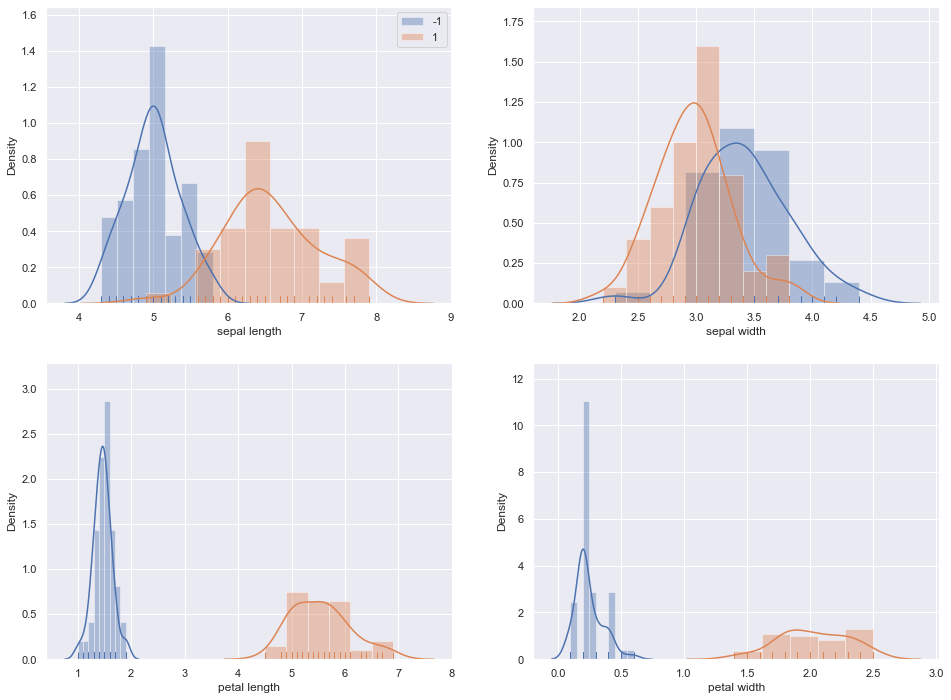

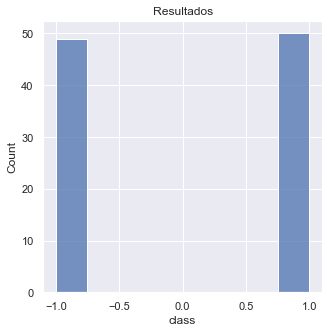

In [25]:
data.loc[data['class'] == 'Iris-setosa', 'class'] = -1
data.loc[data['class'] == 'Iris-virginica', 'class'] = 1

fig, axes = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
for i, column in enumerate(data.columns[:-1]):
    for result in [-1, 1]:
      target = data.loc[data['class'] == result]
      sns.distplot(target[column], rug=True, kde=True, ax=axes[i//2,i%2], label=result)
      if i==0:
        axes[0,0].legend()
        
fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["class"], palette="Blues_d",ax=ax, label=["Iris-virginica", "Iris-versicolor"])
ax.set_title('Resultados')
plt.show()

## División data

In [26]:
data["class"] = data["class"].astype(int)
print(data)
predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["class"]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

    sepal length  sepal width  petal length  petal width  class
0            4.9          3.0           1.4          0.2     -1
1            4.7          3.2           1.3          0.2     -1
2            4.6          3.1           1.5          0.2     -1
3            5.0          3.6           1.4          0.2     -1
4            5.4          3.9           1.7          0.4     -1
..           ...          ...           ...          ...    ...
94           6.7          3.0           5.2          2.3      1
95           6.3          2.5           5.0          1.9      1
96           6.5          3.0           5.2          2.0      1
97           6.2          3.4           5.4          2.3      1
98           5.9          3.0           5.1          1.8      1

[99 rows x 5 columns]


## $\gamma$, R y cota

In [27]:
max_norm_dataset_1 = max_norm(X_train_vals)
g = gamma(X, y)
bound = max_norm_dataset_1**2 / g**2

print("R:", max_norm_dataset_1)
print("Gamma: ", g)
print("Cota: ", bound)
print("Linealmente separables?:", linearly_separable(X, y))

R: 11.11125555461668
Gamma:  1
Cota:  123.46000000000002
Linealmente separables?: True


## Perceptrón directo

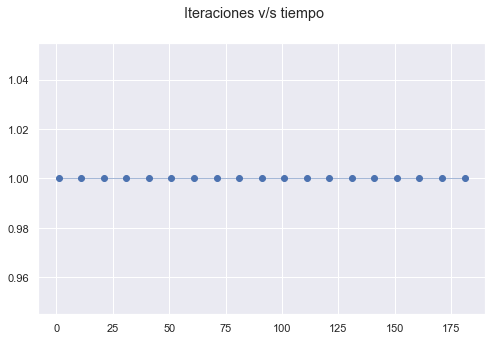

In [28]:
scores = list()
no_iterations = range(1, int(bound*1.5), 10)
for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)    
    train_acc = perceptron.score(X_train_vals, y_train_vals)    
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-o', linewidth=0.5)

### Referencias
#### Binaries

* No Dataset breast-cancer-wisconsin
Dataset iris 